In [ ]:
# initial imports
from teleop_controls.oculus_reader.oculus_reader.reader import OculusReader
from rtde_control import RTDEControlInterface as RTDEControl
from rtde_receive import RTDEReceiveInterface as RTDEReceive
import time
import math
import pyrealsense2 as rs
import cv2
import numpy as np
import jax
import robotiq_gripper
# from AcquireAndDisplay import run_single_camera
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import os
import math
from teleop_controls.misc.subprocess_utils import run_threaded_command
from teleop_controls.misc.transformations import add_angles, euler_to_quat, quat_diff, quat_to_euler, rmat_to_quat

import URBasic
import robotiq_gripper
from mediapipe.tasks.python import BaseOptions
# from mediapipe.tasks.python.vision import GestureRecognizer, GestureRecognizerOptions, GestureRecognizerResult, RunningMode
import mediapipe as mp
from PIL import Image as PILImage
from IPython.display import display, HTML, clear_output
import matplotlib
from matplotlib import animation
from datetime import datetime
import csv
from loguru import logger as loguru_logger
import os
import math
import math3d as m3d

from constants import *

loguru_logger.remove()
log_file = "./session.log"
if not os.path.exists(log_file):
    with open(log_file, 'w'): 
        pass
loguru_logger.add(log_file, mode='w')

# robot constants
ROBOT_IP = '192.168.0.110'
ACCELERATION = 0.5
VELOCITY = 0.5

# set default robot position and parameters
robot_startposition = (
    math.radians(262),
    math.radians(-71),
    math.radians(119),
    math.radians(137),
    math.radians(-80),
    math.radians(-3)
)

max_x = 0.2
max_y = 0.2
hor_rot_max = math.radians(50)
vert_rot_max = math.radians(25)

# Initialize the robot
print("Initializing robot")
robotModel = URBasic.robotModel.RobotModel()
robot = URBasic.urScriptExt.UrScriptExt(host=ROBOT_IP, robotModel=robotModel)
robot.reset_error()
print("Robot initialized")
time.sleep(1)

# move to start position
robot.movej(q=robot_startposition, a=ACCELERATION, v=VELOCITY)
print("Creating gripper...")
gripper = robotiq_gripper.RobotiqGripper()
print("Connecting to gripper...")
gripper.connect(ROBOT_IP, 63352)
print("Activating gripper...")
gripper.activate()

# vector to reorder matrix
def vec_to_reorder_mat(vec):
    X = np.zeros((len(vec), len(vec)))
    for i in range(X.shape[0]):
        ind = int(abs(vec[i])) - 1
        X[i, ind] = np.sign(vec[i])
    return X

# oculus reader session
class OculusReaderSession:
    def __init__(
        self,
        right_controller: bool = True,
        max_lin_vel: float = 1,
        max_rot_vel: float = 1,
        max_gripper_vel: float = 1,
        spatial_coeff: float = 1,
        pos_action_gain: float = 5,
        rot_action_gain: float = 2,
        gripper_action_gain: float = 3,
        rmat_reorder: list = [-2, -1, -3, 4],
        num_frames=100,
        framerate=10,
        control_scale=0.5,
        realsense=False,
        rel_mmt=True
    ):
        self.oculus_reader = OculusReader()
        self.vr_to_global_mat = np.eye(4) # identity matrix
        self.max_lin_vel = max_lin_vel
        self.max_rot_vel = max_rot_vel
        self.max_gripper_vel = max_gripper_vel
        self.spatial_coeff = spatial_coeff
        self.pos_action_gain = pos_action_gain
        self.rot_action_gain = rot_action_gain
        self.gripper_action_gain = gripper_action_gain
        self.global_to_env_mat = vec_to_reorder_mat(rmat_reorder) # probably for conversion of oculus to robot?
        self.controller_id = "r" if right_controller else "l" # defaults to right controller
        self.reset_orientation = True
        self.reset_state() # reset oculus state

        self.realsense = realsense
        self.num_frames = num_frames
        self.framerate = framerate
        self.control_scale = control_scale
        self.controls = []
        # self.relative_pos = []
        self.controllerCentres = []
        self.is_relative = rel_mmt
        self.robot_pose = np.zeros(3)
        # self.first_hand_depth = None
        # self.z_bubble = []
        # self.pitch_pose = 0
        # self.initial_thumb_pos = None
        # self.current_thumb_pos = None
        self.reference_vector = np.array([0, 0, 1])
        self.origin = self.set_lookorigin()
        # self.fist_threshold = 0.2
        self.landmark_drawer = OculusLandmarkDrawer([]) 

        if self.realsense:
            self._init_realsense()
        else:
            self._init_camera()

    # to reset the oculus parameters
    def reset_state(self):
        self._state = {
            "poses": {},
            "buttons": {"A": False, "B": False, "X": False, "Y": False},
            "movement_enabled": False,
            "controller_on": True,
        }
        self.update_sensor = True
        self.reset_origin = True
        self.robot_origin = None
        self.vr_origin = None
        self.vr_state = None

    def _init_realsense(self):
        # first camera
        # first camera is the one facing the user on the table
        self.pipeline = rs.pipeline()
        config = rs.config()

        # specify camera serial number (this is the user camera)
        config.enable_device('128422270567')
        print(f"Device: Intel Realsense D405")
        
        # ctx = rs.context()
        # devices = ctx.query_devices()
        # if not devices:
        #     raise RuntimeError("No device connected")

        # dev = devices[0]
        # print(f"Device: {dev.get_info(rs.camera_info.name)}")
        # sensors = dev.query_sensors()
        # for sensor in sensors:
        #     print(f"Sensor: {sensor.get_info(rs.camera_info.name)}")
        
        # for dev in devices:
        #     print(f"Device: {dev.get_info(rs.camera_info.name)}")
        #     sensors = dev.query_sensors()
        #     for sensor in sensors:
        #         print(f"Sensor: {sensor.get_info(rs.camera_info.name)}")
        config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, self.framerate)
        config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, self.framerate)
        self.pipeline.start(config)

        # second camera
        # second camera displays the robot's wrist camera view for better depth perception
        self.pipeline_robot = rs.pipeline()
        config_robot = rs.config()
        config_robot.enable_device('218622276856')
        print(f"Device: Intel Realsense D405 - Robot Wrist Camera")
        config_robot.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, self.framerate)
        config_robot.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, self.framerate)
        self.pipeline_robot.start(config_robot)   

    def _init_camera(self):
        self.cap = cv2.VideoCapture(0)
        self.cap.set(3, 160)
        self.cap.set(4, 120)

    def _update_internal_state(self, num_wait_sec=5, hz=50):
        last_read_time = time.time()
        while True:
            # Regulate Read Frequency #
            time.sleep(1 / hz)

            # Read Controller
            time_since_read = time.time() - last_read_time
            poses, buttons = self.oculus_reader.get_transformations_and_buttons() # take oculus reader results
            self._state["controller_on"] = time_since_read < num_wait_sec
            if poses == {}: # poses is empty
                continue

            # Determine Control Pipeline #
            toggled = self._state["movement_enabled"] != buttons[self.controller_id.upper() + "G"]
            self.update_sensor = self.update_sensor or buttons[self.controller_id.upper() + "G"]
            self.reset_orientation = self.reset_orientation or buttons[self.controller_id.upper() + "J"]
            self.reset_origin = self.reset_origin or toggled

            # Save Info #
            self._state["poses"] = poses
            self._state["buttons"] = buttons
            self._state["movement_enabled"] = buttons[self.controller_id.upper() + "G"]
            self._state["controller_on"] = True
            last_read_time = time.time()

            # Update Definition Of "Forward" #
            stop_updating = self._state["buttons"][self.controller_id.upper() + "J"] or self._state["movement_enabled"]
            if self.reset_orientation:
                rot_mat = np.asarray(self._state["poses"][self.controller_id])
                if stop_updating:
                    self.reset_orientation = False
                # try to invert the rotation matrix, if not possible, then just use the identity matrix
                try:
                    rot_mat = np.linalg.inv(rot_mat)
                except:
                    print(f"exception for rot mat: {rot_mat}")
                    rot_mat = np.eye(4)
                    self.reset_orientation = True
                self.vr_to_global_mat = rot_mat
        ...
    
    def callback(self, result: GestureRecognizerResult, output_image, timestamp):
        try:
            camera_frame = output_image.numpy_view()
        
            if len(result.hand_landmarks) > 0:
                hand_landmarks = result.hand_landmarks[0]
                landmark = hand_landmarks[0]
                hand_pos = np.array([landmark.x, landmark.y, landmark.z])

                thumb_pos = [hand_landmarks[2].x, hand_landmarks[2].y, hand_landmarks[2].z]
                if self.initial_thumb_pos is None:
                    self.reference_vector = self.calculate_perpendicular_reference_vector(thumb_pos, hand_pos)
                    self.reference_vector_norm = np.linalg.norm(self.reference_vector)
                    self.initial_thumb_pos = self.calculate_rotation(thumb_pos, hand_pos)
                else: 
                    self.current_thumb_pos = self.calculate_rotation(thumb_pos, hand_pos)

                hand_state = self.detect_hand_state(hand_landmarks)
                gripper_control = 1.0 if hand_state == "Closed" else 0.0

                palm_depth = None
                if self.realsense:
                    palm_depth = self.depth_image[int(landmark.y * self.depth_image.shape[0]), int(landmark.x * self.depth_image.shape[1])]
                    hand_pos[2] = palm_depth

                loguru_logger.debug(f"Hand position: {hand_pos}, Gripper control: {gripper_control}")
                self.controls.append((hand_pos, gripper_control))
                #print((hand_pos, gripper_control), end='\r')                    

                if self.is_relative:
                    hand_to = self.relative_movement(camera_frame, landmark)
                    self.relative_pos.append(hand_to)
                    z_command = self.send_robot_command(hand_to, gripper_control, relative=True)
                else:
                    z_command = self.send_robot_command(hand_pos, gripper_control)
            else:
                z_command = self._handle_no_landmarks()

            if result.hand_landmarks:
                self._update_display(camera_frame, hand_landmarks, z_command, palm_depth)
            else:
                height, width, _ = camera_frame.shape
                camera_frame = np.ones((height, width, 3), dtype=np.uint8) * 255
                self.camera_display_handle.update(PILImage.fromarray(camera_frame))
        except Exception as e:
            loguru_logger.error(f"Error in callback: {e}")

    def _handle_no_landmarks(self):
        if self.controls and self.relative_pos:
            self.controls.append(self.controls[-1])
            if self.is_relative:
                self.relative_pos.append(np.zeros(2))
                z_command = self.send_robot_command(np.zeros(2), self.controls[-1][1], relative=True)
            else:
                z_command = self.send_robot_command(self.controls[-1])
        else:
            self.controls.append((np.zeros(3), 0.0))
            if self.is_relative:
                z_command = self.send_robot_command(np.zeros(2), 0.0, relative=True)
            else:
                z_command = self.send_robot_command(np.zeros(3), 0.0)
        return z_command

    def _update_display(self, camera_frame, hand_landmarks, z_command, pd): 
        height, width, _ = camera_frame.shape
        camera_frame = np.ones((height, width, 3), dtype=np.uint8) * 255

        if self.realsense:
            frame_with_landmarks, self.handcenters = self.landmark_drawer.draw_box(camera_frame, hand_landmarks, z_c=z_command, palm_depth=pd, rotation_vector=self.reference_vector)
        else:
            frame_with_landmarks, self.handcenters = self.landmark_drawer.draw_box(camera_frame, hand_landmarks, rotation_vector=self.reference_vector)
        self.camera_display_handle.update(PILImage.fromarray(frame_with_landmarks))

    def display_video(self, frames, framerate=30):
        height, width, _ = frames[0].shape
        dpi = 70
        orig_backend = matplotlib.get_backend()
        matplotlib.use('Agg')
        fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
        matplotlib.use(orig_backend)
        ax.set_axis_off()
        ax.set_aspect('equal')
        ax.set_position([0, 0, 1, 1])
        im = ax.imshow(frames[0])

        def update(frame):
            im.set_data(frame)
            return [im]

        interval = 1000 / framerate
        anim = animation.FuncAnimation(fig, func=update, frames=frames,
                                       interval=interval, blit=True, repeat=False)
        return HTML(anim.to_html5_video())  ##look into this 

    # def set_lookorigin(self):
    #     position = robot.get_actual_tcp_pose() 
    #     #print("Initial Position:",position)
    #     orig = m3d.Transform(position)
    #     return orig
    
    # def calculate_fist_threshold(self, hand_landmarks):
    #     try:
    #         x1, y1 = hand_landmarks[0].x, hand_landmarks[0].y
    #         x2, y2 = hand_landmarks[12].x, hand_landmarks[12].y
    #         hand_size = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    #         thresh = 0.55 * hand_size
    #         loguru_logger.debug(f"Calculated fist threshold: {thresh}")
    #         return thresh
    #     except Exception as e:
    #         loguru_logger.error(f"Error in calculate_fist_threshold: {e}")
    #         return 0.2

    # def detect_hand_state(self, hand_landmarks):
    #     try:
    #         if self.fist_threshold == 0.2:
    #             self.fist_threshold = self.calculate_fist_threshold(hand_landmarks)

    #         palm_center = hand_landmarks[0]
    #         tip = hand_landmarks[12]
    #         distance = np.linalg.norm([tip.x - palm_center.x, tip.y - palm_center.y, tip.z - palm_center.z])
    #         if distance < self.fist_threshold:
    #             return "Closed"
    #         return "Open"
        
    #     except Exception as e:
    #         loguru_logger.error(f"Error in detect_hand_state: {e}, return 'Open'")
    #         return "Open"
        
    # def calculate_perpendicular_reference_vector(self, initial_thumb_pos, hand_pos):
    #     original_thumb_vector = initial_thumb_pos - hand_pos
    #     reference_vector = np.array([0, 0, 1])  # z-axis
    #     perpendicular_reference_vector = np.cross(original_thumb_vector, reference_vector)
    #     return perpendicular_reference_vector / np.linalg.norm(perpendicular_reference_vector)

    # def calculate_rotation(self, pos, hand_pos):
    #     vector_thumb = np.subtract(pos, hand_pos)  
    #     vector_thumb_norm = np.linalg.norm(vector_thumb)
    #     cosine_angle = np.dot(vector_thumb, self.reference_vector) / (vector_thumb_norm * self.reference_vector_norm)
    #     angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0)) 
    #     return angle
    
    # def relative_movement(self, frame, landmark):
    #     try:
    #         handcenters = []
    #         height, width, _ = frame.shape            
    #         video_resolution = (width, height)
    #         video_midpoint = (int(video_resolution[0] / 2), int(video_resolution[1] / 2))

    #         landmark_x = int(landmark.x * width)
    #         landmark_y = int(landmark.y * height)

    #         hand_center = (landmark_x, landmark_y)
    #         position_from_center = (hand_center[0] - video_midpoint[0], hand_center[1] - video_midpoint[1])
    #         handcenters.append(position_from_center)

    #         return handcenters
    #     except Exception as e:
    #         loguru_logger.error(f"Error finding relative position to robot: {e}")

    # def check_z(self, z, t_ext=700):
    #     if z == 0:
    #         return 0

    #     if self.first_hand_depth is None:
    #         self.first_hand_depth = z
    #         self.z_bubble = [self.first_hand_depth - t_ext, self.first_hand_depth + t_ext]

    #     try:
    #         loguru_logger.debug(f"z: {z}, z_first: {self.first_hand_depth}")
    #         if z < self.z_bubble[0]:
    #             return 1
    #         elif z > self.z_bubble[1]:
    #             return -1
    #         else:
    #             return 0

    #     except Exception as e:
    #         loguru_logger.error(f"Error checking z: {e}")

    # def set_rotation(self, angle, buffer=0.3):  # in rad
    #     try:
    #         angle_diff = angle - self.initial_thumb_pos
    #         angle_bubble = [-buffer, buffer]
    #         if angle_diff < angle_bubble[0]:
    #             return 1
    #         elif angle_diff > angle_bubble[1]:
    #             return -1
    #         else:
    #             return 0
    #     except Exception as e:
    #         loguru_logger.error(f"Error setting pitch angle: {e}")

    def send_robot_command(self, hand_pos, gripper_control, relative=True, speed=50, force=50, m_per_pixel=0.00002, rotation_scale=-0.5):
        if relative: 
            try:
                hand_from_center = np.array(hand_pos) 
                z_pos = 0

                if self.realsense:
                    z_pos = self.check_z(self.controls[-1][0][2])

                deadzone = 30  # Increase deadzone for xy movement here (square)
                x_pos = hand_from_center[0][0] if np.abs(hand_from_center[0][0]) >= deadzone else 0
                y_pos = hand_from_center[0][1] if np.abs(hand_from_center[0][1]) >= deadzone else 0

                scaled_hand_pos = [x_pos * m_per_pixel, y_pos * m_per_pixel]
                robot_target = np.array(self.robot_pose[:2]) + scaled_hand_pos
                z_target = self.robot_pose[2] + (z_pos * 0.0015)
                robot_target = np.append(robot_target, z_target)
                self.robot_pose = robot_target

                x, y, z = robot_target
                #y *= -1
                x *= -1
                xyz_coords = m3d.Vector(x, y, z)
                x_rot = x / max_x * hor_rot_max
                y_rot = y / max_y * vert_rot_max * -1 

                tcp_rotation_rpy = [y_rot, x_rot, 0] 
                # pitch_target = self.pitch_pose + self.set_rotation(self.current_thumb_pos)
                # self.pitch_pose = pitch_target
                # tcp_rotation_rpy = [y_rot, x_rot, pitch_target*0.01]
                tcp_orient = m3d.Orientation.new_euler(tcp_rotation_rpy, encoding='xyz')
                position_vec_coords = m3d.Transform(tcp_orient, xyz_coords)

                next_pose = (self.origin * position_vec_coords).get_pose_vector()

                loguru_logger.debug(f"target_pos: {next_pose}")
                loguru_logger.debug(f"robot_pos: {robot.get_actual_tcp_pose()}")

                self.tool_traj.append((time.time(), robot.get_actual_tcp_pose().tolist()))
                self.traj.append((time.time(), robot.get_actual_joint_positions().tolist()))
                self.next_traj.append((time.time(), (next_pose).tolist())) 
                self.tool.append((time.time(), gripper_control))
                #print(next_pose)
                robot.set_realtime_pose(next_pose)
                

                if gripper_control != self.controls[-2][1]:
                    gripper_control_value = int(gripper_control * 255)
                    loguru_logger.debug(f"gripper pos: {gripper.get_current_position()}")
                    gripper.move_and_wait_for_pos(gripper_control_value, speed, force)

                return z_pos
            except Exception as e:
                loguru_logger.error(f"Error sending command to robot (relative): {e}")
        else:
            print('Cannot run non-relative movement, in development')
            loguru_logger.error(f"No non-relative movement")

    def start(self, obs_dict, include_info=False):
        self.tool_traj = []
        self.traj = []
        self.next_traj = []
        self.tool = []

        self.camera_display_handle = display(None, display_id=True)
        self.depth_image = None

        if self._state["poses"] == {}:
            action = np.zeros(7)
            if include_info:
                return action, {}
            else: return action
        

        # options = GestureRecognizerOptions(
        #     base_options=BaseOptions(model_asset_path=MODEL_ASSET_PATH),
        #     running_mode=RunningMode.LIVE_STREAM,
        #     result_callback=self.callback
        # )

        timestamp = 0
        try:
            # with GestureRecognizer.create_from_options(options) as recognizer:
            while True:
                if self.realsense:
                    frames = self.pipeline.wait_for_frames()
                    color_frame = frames.get_color_frame()
                    depth_frame = frames.get_depth_frame()

                    # second camera:
                    secondpov_frames = self.pipeline_robot.wait_for_frames()
                    secondpov_color_frame = secondpov_frames.get_color_frame()
                    secondpov_depth_frame = secondpov_frames.get_depth_frame()

                    if not depth_frame or not color_frame:
                        continue                        
                    frame = np.asanyarray(color_frame.get_data())
                    self.depth_image = np.asanyarray(depth_frame.get_data())

                    if not secondpov_color_frame or not secondpov_depth_frame:
                        continue
                    secondpov_frame = np.asanyarray(secondpov_color_frame.get_data())
                    
                else:
                    ret, frame = self.cap.read()
                    if not ret:
                        break
                
                timestamp += 1

                _calculate_action(obs_dict["robot_state"], include_info = include_info)
                # mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
                # recognizer.recognize_async(mp_image, timestamp)

                # show camera views stacked together horizontally
                stacked_viewframes = np.hstack((cv2.flip(frame, 1), secondpov_frame))
                cv2.imshow("Realsense", stacked_viewframes)
                
                if cv2.waitKey(2000 // self.framerate) & 0xFF == ord('q'):
                    break

                if timestamp == self.num_frames:
                    break
            robot.close()
                    
        except Exception as e:
            loguru_logger.error(f"Error in start method: {e}")
        finally:
            self.save_trajectories()
            self.close()

    def save_trajectories(self):
        curr_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        base_path = os.path.join('experiments', 'traj', f"exp_{curr_time}")

        os.makedirs(base_path, exist_ok=True)

        trajectories = {
            'tool_traj': self.tool_traj,
            'joint_traj': self.traj,
            'next_traj': self.next_traj,
            'tool': self.tool
        }

        for name, trajectory in trajectories.items():
            file_path = os.path.join(base_path, f'{name}.csv')

            with open(file_path, 'w', newline='') as file:
                writer = csv.writer(file)

                if len(trajectory) > 0 and isinstance(trajectory[0][1], list):
                    header = ['Timestamp'] + [f't{i+1}' for i in range(len(trajectory[0][1]))]
                    flattened_data = [(time, *pose) for time, pose in trajectory]
                else:
                    header = ['Timestamp', 'Value']
                    flattened_data = [(time, value) for time, value in trajectory]

                writer.writerow(header)
                writer.writerows(flattened_data)

    def close(self):
        if self.realsense:
            self.pipeline.stop()
            self.pipeline_robot.stop()
        else:
            self.cap.release()
        cv2.destroyAllWindows()

class OculusLandmarkDrawer:
    def __init__(self, camera_frames):
        self.mp_hands = mp.solutions.hands
        self.mp_drawing = mp.solutions.drawing_utils
        self.drawing_spec = self.mp_drawing.DrawingSpec(thickness=2, circle_radius=2)

    def draw_box(self, frame, landmarks, z_c=0, palm_depth=None, rotation_vector=None):
        try:
            frame = np.copy(frame)
            height, width, _ = frame.shape
            video_midpoint = (int(width / 2), int(height / 2))

            hand_center = (int(landmarks[0].x * width), int(landmarks[0].y * height))
            thumb_tip = (int(landmarks[2].x * width), int(landmarks[2].y * height))

            box_size = 10
            startX = max(0, hand_center[0] - box_size)
            startY = max(0, hand_center[1] - box_size)
            endX = min(width, hand_center[0] + box_size)
            endY = min(height, hand_center[1] + box_size)

            position_from_center = (hand_center[0] - video_midpoint[0], hand_center[1] - video_midpoint[1])
            framewbox = cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 0, 255), 2)
            framewbox = cv2.line(framewbox, video_midpoint, hand_center, (0, 200, 0), 2)
            
            if palm_depth is not None:
                if z_c == 1:
                    color, label = ((0, 255, 255), 'FORWARD')
                elif z_c == -1:
                    color, label = ((0, 255, 0), 'BACKWARD')
                else:
                    color, label = ((0, 0, 0), 'NEUTRAL')
                text = f"{label} | Palm depth: {palm_depth} mm"
                framewbox = cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

                position_text = (f"Palm (x: {position_from_center[0]}, y: {-position_from_center[1]})")
                framewbox = cv2.putText(framewbox, position_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

            if rotation_vector is not None:
                scale = 50
                end_x = int(hand_center[0] + rotation_vector[0] * scale)
                end_y = int(hand_center[1] + rotation_vector[1] * scale)

                framewbox = cv2.arrowedLine(framewbox, hand_center, (end_x, end_y), (255, 0, 0), 2, tipLength=0.1)
                framewbox = cv2.arrowedLine(framewbox, hand_center, thumb_tip, (0, 255, 255), 2, tipLength=0.1)

            return framewbox, [position_from_center] 
        except Exception as e:
            loguru_logger.error(f"Error in draw_box: {e}")


2025-03-18 09:51:11.562411: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-18 09:51:11.614085: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-18 09:51:12.913275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Initializing robot
waiting for everything to be ready
Robot Pose: [-0.4155,  1.0273,  0.1302,   -1.6844, -0.2818, -0.2982]
Robot joint positions: [ 5.0366, -0.6216,  1.6416,    2.2565, -1.9242, -0.3251]
Robot initialized
Creating gripper...
Connecting to gripper...
Activating gripper...
Gripper auto-calibrated to [3, 228]


skipping package - unexpected packet_size - length:  124 331 85
Device: Intel Realsense D405
skipping package - unexpected packet_size - length:  4096 56180 177
Device: Intel Realsense D405 - Robot Wrist Camera
skipping package - unexpected packet_size - length:  4096 56664 191


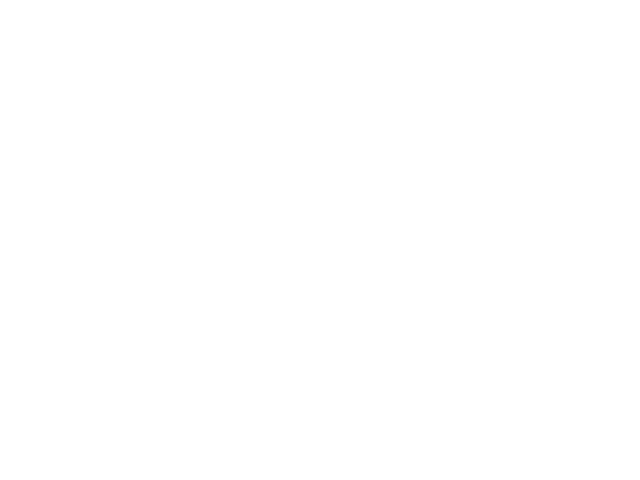

I0000 00:00:1742305894.400986   69947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742305894.567584   70200 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 570.124.06), renderer: NVIDIA RTX A6000/PCIe/SSE2
W0000 00:00:1742305894.568215   69947 gesture_recognizer_graph.cc:129] Hand Gesture Recognizer contains CPU only ops. Sets HandGestureRecognizerGraph acceleration to Xnnpack.
I0000 00:00:1742305894.569568   69947 hand_gesture_recognizer_graph.cc:250] Custom gesture classifier is not defined.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


skipping package - unexpected packet_size - length:  123 331 85
skipping package - unexpected packet_size - length:  3518 16347 116
Robot Pose: [ 0.1647,  1.0599,  0.3101,   -1.6520,  0.9764, -0.8685]
Robot joint positions: [ 4.6470, -0.8241,  1.4748,    2.9998, -2.6090,  0.3513]


In [2]:
# Initialize the robot and the session
robot_position20 = [0,0] # not sure what this does, not referenced elsewhere
robot.init_realtime_control()
time.sleep(1)

# Start the hand tracking session
session = HandTrackingSession(num_frames=5000, framerate=30, control_scale=0.5, realsense=True, rel_mmt=True) 
session.start()


In [3]:
# # Initialize the robot and the session
# robot_position = [0,0] # not sure what this does, not referenced elsewhere
# robot.init_realtime_control()
# time.sleep(1)

# # Start the hand tracking session
# session = HandTrackingSession(num_frames=2000, framerate=30, control_scale=0.5, realsense=True, rel_mmt=True) 
# session.start()


In [3]:
robot.close()
session.pipeline.stop
session.pipeline_robot.stop
cv2.destroyAllWindows()


KeyboardInterrupt: 

In [ ]:
# initial imports
from teleop_controls.oculus_reader.oculus_reader.reader import OculusReader
from rtde_control import RTDEControlInterface as RTDEControl
from rtde_receive import RTDEReceiveInterface as RTDEReceive
import time
import math
import pyrealsense2 as rs
import cv2
import numpy as np
import jax
import robotiq_gripper
# from AcquireAndDisplay import run_single_camera
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from scipy.spatial.transform import Rotation as R
import os
import math
from teleop_controls.misc.subprocess_utils import run_threaded_command
from teleop_controls.misc.transformations import add_angles, euler_to_quat, quat_diff, quat_to_euler, rmat_to_quat

# TO-DO:
# implement pipeline
# scale vr action to robot action
# deploy action on robot
# display primary realsense camera stream

# LOGGING:
# Record robot actions, joint poses, camera views, and task name as npy file (see ur5 berkeley dataset format)
# conversion into rlds (later)

def vec_to_reorder_mat(vec):
    X = np.zeros((len(vec), len(vec)))
    for i in range(X.shape[0]):
        ind = int(abs(vec[i])) - 1
        X[i, ind] = np.sign(vec[i])
    return X

class VRPolicy:
    def __init__(
        self,
        right_controller: bool = True,
        max_lin_vel: float = 1,
        max_rot_vel: float = 1,
        max_gripper_vel: float = 1,
        spatial_coeff: float = 1,
        pos_action_gain: float = 5,
        rot_action_gain: float = 2,
        gripper_action_gain: float = 3,
        rmat_reorder: list = [-2, -1, -3, 4],
    ):
        self.oculus_reader = OculusReader()
        self.vr_to_global_mat = np.eye(4)
        self.max_lin_vel = max_lin_vel
        self.max_rot_vel = max_rot_vel
        self.max_gripper_vel = max_gripper_vel
        self.spatial_coeff = spatial_coeff
        self.pos_action_gain = pos_action_gain
        self.rot_action_gain = rot_action_gain
        self.gripper_action_gain = gripper_action_gain
        self.global_to_env_mat = vec_to_reorder_mat(rmat_reorder)
        self.controller_id = "r" if right_controller else "l"
        self.reset_orientation = True
        self.reset_state()

        # Start State Listening Thread #
        run_threaded_command(self._update_internal_state)

    def reset_state(self):
        self._state = {
            "poses": {},
            "buttons": {"A": False, "B": False, "X": False, "Y": False},
            "movement_enabled": False,
            "controller_on": True,
        }
        self.update_sensor = True
        self.reset_origin = True
        self.robot_origin = None
        self.vr_origin = None
        self.vr_state = None

    def _update_internal_state(self, num_wait_sec=5, hz=50):
        last_read_time = time.time()
        while True:
            # Regulate Read Frequency #
            time.sleep(1 / hz)

            # Read Controller
            time_since_read = time.time() - last_read_time
            poses, buttons = self.oculus_reader.get_transformations_and_buttons()
            self._state["controller_on"] = time_since_read < num_wait_sec
            if poses == {}:
                continue

            # Determine Control Pipeline #
            toggled = self._state["movement_enabled"] != buttons[self.controller_id.upper() + "G"]
            self.update_sensor = self.update_sensor or buttons[self.controller_id.upper() + "G"]
            self.reset_orientation = self.reset_orientation or buttons[self.controller_id.upper() + "J"]
            self.reset_origin = self.reset_origin or toggled

            # Save Info #
            self._state["poses"] = poses
            self._state["buttons"] = buttons
            self._state["movement_enabled"] = buttons[self.controller_id.upper() + "G"]
            self._state["controller_on"] = True
            last_read_time = time.time()

            # Update Definition Of "Forward" #
            stop_updating = self._state["buttons"][self.controller_id.upper() + "J"] or self._state["movement_enabled"]
            if self.reset_orientation:
                rot_mat = np.asarray(self._state["poses"][self.controller_id])
                if stop_updating:
                    self.reset_orientation = False
                # try to invert the rotation matrix, if not possible, then just use the identity matrix
                try:
                    rot_mat = np.linalg.inv(rot_mat)
                except:
                    print(f"exception for rot mat: {rot_mat}")
                    rot_mat = np.eye(4)
                    self.reset_orientation = True
                self.vr_to_global_mat = rot_mat

    def _process_reading(self):
        rot_mat = np.asarray(self._state["poses"][self.controller_id])
        rot_mat = self.global_to_env_mat @ self.vr_to_global_mat @ rot_mat
        vr_pos = self.spatial_coeff * rot_mat[:3, 3]
        vr_quat = rmat_to_quat(rot_mat[:3, :3])
        vr_gripper = self._state["buttons"]["rightTrig" if self.controller_id == "r" else "leftTrig"][0]

        self.vr_state = {"pos": vr_pos, "quat": vr_quat, "gripper": vr_gripper}

    def _limit_velocity(self, lin_vel, rot_vel, gripper_vel):
        """Scales down the linear and angular magnitudes of the action"""
        lin_vel_norm = np.linalg.norm(lin_vel)
        rot_vel_norm = np.linalg.norm(rot_vel)
        gripper_vel_norm = np.linalg.norm(gripper_vel)
        if lin_vel_norm > self.max_lin_vel:
            lin_vel = lin_vel * self.max_lin_vel / lin_vel_norm
        if rot_vel_norm > self.max_rot_vel:
            rot_vel = rot_vel * self.max_rot_vel / rot_vel_norm
        if gripper_vel_norm > self.max_gripper_vel:
            gripper_vel = gripper_vel * self.max_gripper_vel / gripper_vel_norm
        return lin_vel, rot_vel, gripper_vel

    def _calculate_action(self, state_dict, include_info=False):
        # Read Sensor #
        if self.update_sensor:
            self._process_reading()
            self.update_sensor = False

        # Read Observation
        robot_pos = np.array(state_dict["cartesian_position"][:3])
        robot_euler = state_dict["cartesian_position"][3:]
        robot_quat = euler_to_quat(robot_euler)
        robot_gripper = state_dict["gripper_position"]

        # Reset Origin On Release #
        if self.reset_origin:
            self.robot_origin = {"pos": robot_pos, "quat": robot_quat}
            self.vr_origin = {"pos": self.vr_state["pos"], "quat": self.vr_state["quat"]}
            self.reset_origin = False

        # Calculate Positional Action #
        robot_pos_offset = robot_pos - self.robot_origin["pos"]
        target_pos_offset = self.vr_state["pos"] - self.vr_origin["pos"]
        pos_action = target_pos_offset - robot_pos_offset

        # Calculate Euler Action #
        robot_quat_offset = quat_diff(robot_quat, self.robot_origin["quat"])
        target_quat_offset = quat_diff(self.vr_state["quat"], self.vr_origin["quat"])
        quat_action = quat_diff(target_quat_offset, robot_quat_offset)
        euler_action = quat_to_euler(quat_action)

        # Calculate Gripper Action #
        gripper_action = (self.vr_state["gripper"] * 1.5) - robot_gripper

        # Calculate Desired Pose #
        target_pos = pos_action + robot_pos
        target_euler = add_angles(euler_action, robot_euler)
        target_cartesian = np.concatenate([target_pos, target_euler])
        target_gripper = self.vr_state["gripper"]

        # Scale Appropriately #
        pos_action *= self.pos_action_gain
        euler_action *= self.rot_action_gain
        gripper_action *= self.gripper_action_gain
        lin_vel, rot_vel, gripper_vel = self._limit_velocity(pos_action, euler_action, gripper_action)

        # Prepare Return Values #
        info_dict = {"target_cartesian_position": target_cartesian, "target_gripper_position": target_gripper}
        action = np.concatenate([lin_vel, rot_vel, [gripper_vel]])
        action = action.clip(-1, 1)

        # Return #
        if include_info:
            return action, info_dict
        else:
            return action

    def get_info(self):
        return {
            "success": self._state["buttons"]["A"] if self.controller_id == 'r' else self._state["buttons"]["X"],
            "failure": self._state["buttons"]["B"] if self.controller_id == 'r' else self._state["buttons"]["Y"],
            "movement_enabled": self._state["movement_enabled"],
            "controller_on": self._state["controller_on"],
        }

    def forward(self, obs_dict, include_info=False):
        if self._state["poses"] == {}:
            action = np.zeros(7)
            if include_info:
                return action, {}
            else:
                return action
        return self._calculate_action(obs_dict["robot_state"], include_info=include_info)

In [ ]:
# deployment on UR10e

# constants
ROBOT_IP = '192.168.0.110'
GRIPPER_PORT = 63352

# Parameters
rtde_frequency = 500.0
flags = RTDEControl.FLAG_VERBOSE | RTDEControl.FLAG_UPLOAD_SCRIPT
ur_cap_port = 50002

# ur_rtde realtime priorities
rt_receive_priority = 90
rt_control_priority = 85

# initialize ur-rtde recieve and control commands
rtde_r = RTDEReceive(ROBOT_IP, rtde_frequency, [], True, False, rt_receive_priority)
rtde_c = RTDEControl(ROBOT_IP, rtde_frequency, flags, ur_cap_port, rt_control_priority)

# set robot joints start position
robot_startposition = (
    math.radians(252),
    math.radians(-77),
    math.radians(132),
    math.radians(161),
    math.radians(-67),
    math.radians(-22)
)

print("Start Position:", robot_startposition)

# move robot to preset start position
rtde_c.moveJ(robot_startposition)

# initialize gripper
print("Creating gripper...")
gripper = robotiq_gripper.RobotiqGripper()
print("Connecting to gripper...")
gripper.connect(ROBOT_IP, GRIPPER_PORT)
print("Activating gripper...")
gripper.activate()


In [ ]:
# UNDERSTANDING THE CHANGE OF FRAME OF REFERENCE

import numpy as np

# this function applies reordering to vec
# when vec is [-2, -1, -3, 4], we get
# [[ 0. -1.  0.  0.]
#  [-1.  0.  0.  0.]
#  [ 0.  0. -1.  0.]
#  [ 0.  0.  0.  1.]]
# which corresponds to:
# - map the x axis to the -y axis
# - map the y axis to the -x axis
# - map the z axis to the -z axis
# this would cause the coordinate system of oculus reader to match with the robot base frame
# need to check what oculus reader frame looks like
def vec_to_reorder_mat(vec):
    X = np.zeros((len(vec), len(vec)))
    for i in range(X.shape[0]):
        ind = int(abs(vec[i])) - 1
        X[i, ind] = np.sign(vec[i])
    return X

rot_mat = np.asarray([[-0.628429 , -0.694163 ,  0.351017 , -0.249769 ],
       [-0.684221 ,  0.278634 , -0.673947 ,  0.0486907],
       [ 0.370024 , -0.663702 , -0.650063 , -0.135777 ],
       [ 0.       ,  0.       ,  0.       ,  1.       ]])

rmat_reorder = [-2, -1, -3, 4]

# here, we take the inverse of the rot_mat matrix
# the inverse is supposed to undo the the original transformation caused by rot_mat
# basically it takes us to the original state (before the rot_mat transformation is applied)
try:
    rot_mat1 = np.linalg.inv(rot_mat)
except:
    print(f"exception for rot mat: {rot_mat}")
    rot_mat1 = np.eye(4)

vr_to_global_mat = rot_mat1

global_to_env_mat = vec_to_reorder_mat(rmat_reorder)

print(global_to_env_mat)

print(vr_to_global_mat)
print(rot_mat1)

# to get the new mapped axes, multiply the transformations with the original rotation matrix
# the first matrix (global_to_env_mat) applies the axes transformations
# the second matrix (vr_to_global_mat) is multiplied to this transformed frame to "reset" to the untransformed start coordinate
# finally, rot_mat is multiplied to this transformed system to get the new transformation in the mapped axis
rot_mat = global_to_env_mat @ vr_to_global_mat @ rot_mat
print(rot_mat)


[[ 0. -1.  0.  0.]
 [-1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0.  1.]]
[[-0.62843023 -0.68422103  0.37002416 -0.07340642]
 [-0.69416399  0.278634   -0.66370168 -0.27706295]
 [ 0.35101792 -0.67394721 -0.65006322  0.03222472]
 [ 0.          0.          0.          1.        ]]
[[-0.62843023 -0.68422103  0.37002416 -0.07340642]
 [-0.69416399  0.278634   -0.66370168 -0.27706295]
 [ 0.35101792 -0.67394721 -0.65006322  0.03222472]
 [ 0.          0.          0.          1.        ]]
[[ 1.38777878e-16 -1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  2.77555756e-17 -2.77555756e-17  2.77555756e-17]
 [ 5.55111512e-17 -5.55111512e-17 -1.00000000e+00 -1.38777878e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [ ]:
# [C] = (3[I]-([M] * [M]T))/2
# correction matrix to make the matrix orthogonal (otherwise you cannot do 4x4 to quaternion transformation)



In [ ]:
({'r': array([[-0.628429 , -0.694163 ,  0.351017 , -0.249769 ],
       [-0.684221 ,  0.278634 , -0.673947 ,  0.0486907],
       [ 0.370024 , -0.663702 , -0.650063 , -0.135777 ],
       [ 0.       ,  0.       ,  0.       ,  1.       ]])}, {'A': False, 'B': False, 'RThU': False, 'RJ': False, 'RG': False, 'RTr': False, 'rightJS': (0.0, 0.0), 'rightTrig': (0.0,), 'rightGrip': (0.0,)})
({'r': array([[-0.591525 , -0.799272 , -0.106125 , -0.183564 ],
       [-0.0364141,  0.15797  , -0.986772 ,  0.0262466],
       [ 0.805464 , -0.579836 , -0.122548 , -0.24756  ],
       [ 0.       ,  0.       ,  0.       ,  1.       ]])}, {'A': False, 'B': False, 'RThU': True, 'RJ': False, 'RG': False, 'RTr': False, 'rightJS': (0.0, 0.0), 'rightTrig': (0.0,), 'rightGrip': (0.0,)})
({'r': array([[-0.430683  , -0.833189  , -0.346854  , -0.103734  ],
       [ 0.115397  ,  0.33033   , -0.936784  , -0.00776023],
       [ 0.895095  , -0.443483  , -0.0461197 , -0.311232  ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])}, {'A': False, 'B': False, 'RThU': True, 'RJ': False, 'RG': False, 'RTr': False, 'rightJS': (0.0, 0.0), 'rightTrig': (0.0,), 'rightGrip': (0.0,)})

/home/demoaccount/Data/demoaccount2/ARC/arc_handtrack/lib/python3.8/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


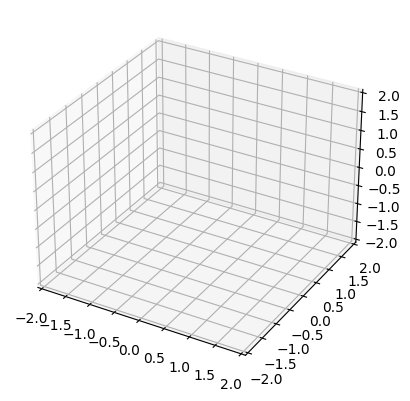

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Define the transformation matrix (global_to_env_mat)
global_to_env_mat = np.array([
    [ 0., -1.,  0.,  0.],
    [-1.,  0.,  0.,  0.],
    [ 0.,  0., -1.,  0.],
    [ 0.,  0.,  0.,  1.]
])

# Define axis vectors for x, y, z in global coordinates (homogeneous)
axes = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

# Apply the transformation to the axes (ignoring the homogeneous part)
transformed_axes = global_to_env_mat[:3, :3] @ axes.T

# Set up the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)

# Create the line objects for x, y, z axes
line_x, = ax.plot([], [], [], color='r', lw=2)
line_y, = ax.plot([], [], [], color='g', lw=2)
line_z, = ax.plot([], [], [], color='b', lw=2)

# Function to update the plot for each frame
def update(frame):
    # Create rotation matrix for each frame (rotation around the Z-axis)
    angle = frame * np.pi / 180  # Convert to radians
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])
    
    # Rotate the axes vectors
    rotated_axes = rotation_matrix @ axes.T
    
    # Update the line data with the rotated axis
    line_x.set_data([0, rotated_axes[0, 0]], [0, rotated_axes[1, 0]])
    line_x.set_3d_properties([0, rotated_axes[2, 0]])
    
    line_y.set_data([0, rotated_axes[0, 1]], [0, rotated_axes[1, 1]])
    line_y.set_3d_properties([0, rotated_axes[2, 1]])
    
    line_z.set_data([0, rotated_axes[0, 2]], [0, rotated_axes[1, 2]])
    line_z.set_3d_properties([0, rotated_axes[2, 2]])
    
    return line_x, line_y, line_z

# Create the animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=100)

plt.show()
